In [37]:
import os
import yaml
from astropy.table import Table
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import fitsio
import datetime
%matplotlib inline

In [38]:
import desisim
import desisurvey
import desimodel.io
import desimodel.footprint

# Environment Variables 

Set some environment variables and create output directories

`$DESISURVEY` = `${SCRATCH}`/quicksurvey_example/survey/

In [39]:
alldirs = {}
basedir = os.path.join(os.getenv('SCRATCH'),'quicksurvey_example')
surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir,'survey')
fiberassigndir =  os.path.join(basedir, 'fiberassign')
alldirs['surveydir'] = surveydir
alldirs['fiberassigndir'] = fiberassigndir

brighttargetdir = os.path.join(basedir,'targets/no_spectra/bright')
darktargetdir = os.path.join(basedir,'targets/no_spectra/dark')
alldirs['brighttargetdir'] = brighttargetdir
alldirs['darktargetdir'] = darktargetdir

zcatbrightdir = os.path.join(basedir,'zcat/bright')
zcatdarkdir = os.path.join(basedir,'zcat/dark')
alldirs['zcatbrightdir'] = zcatbrightdir
alldirs['zcatdarkdir'] = zcatdarkdir

alltargetdir = os.path.join(basedir,'targets/no_spectra/bright')
zcatalldir = os.path.join(basedir,'zcat/all')
alldirs['alltargetdir'] = alltargetdir
alldirs['zcatalldir'] = zcatalldir

In [40]:
for k in alldirs.keys():
    print('Creating {}: {}'.format(k, alldirs[k]))
    os.makedirs(alldirs[k], exist_ok=True)

Creating zcatalldir: /global/cscratch1/sd/forero/quicksurvey_example/zcat/all
Creating surveydir: /global/cscratch1/sd/forero/quicksurvey_example/survey
Creating brighttargetdir: /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright
Creating zcatdarkdir: /global/cscratch1/sd/forero/quicksurvey_example/zcat/dark
Creating fiberassigndir: /global/cscratch1/sd/forero/quicksurvey_example/fiberassign
Creating alltargetdir: /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright
Creating zcatbrightdir: /global/cscratch1/sd/forero/quicksurvey_example/zcat/bright
Creating darktargetdir: /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark


# Survey Plan

We create a list of tiles to be observed by running `surveyplan` and `surveysim` for the **first year** of the survey.
The configuration file we used is

In [41]:
cmd  = 'cat  {}/config.yaml'.format(os.environ['DESISURVEY_OUTPUT'])
! $cmd

####################################################################
# Configuration data for DESI survey planning and scheduling.
####################################################################

#-------------------------------------------------------------------
# Location of the Mayall at KPNO
#-------------------------------------------------------------------

location:
    latitude: 31.963972222 deg
    longitude: -111.599336111 deg
    elevation: 2120 m
    pressure: 78318 Pa    # from 1976 standard atmosphere model
    temperature: 5 C      # a guess at mean night-time temperature
    timezone: US/Arizona

#-------------------------------------------------------------------
# Observing calendar.
#-------------------------------------------------------------------

# Survey nominally starts on night of this date. Format is YYYY-MM-DD.
first_day: 2019-12-01

# Survey nominally ends on morning of this date. Format is YYYY-MM-DD.
last_day: 2020-11-30

# First night of monsoon 

And the detailed script is

In [42]:
cmd  = 'cat  {}/surveysim_baseline.sh'.format(os.environ['DESISURVEY_OUTPUT'])
! $cmd

#!/bin/bash
#############################################################################
# Simulate the baseline survey strategy described in DESI-doc-1767-v3.
# Note that this is one random realization of the observing conditions.
# Change the random seed for a different realization.
# This will take ~1 hours to run and writes ~50MB to $DESISURVEY_OUTPUT.
#############################################################################
export DESISURVEY_OUTPUT=${SCRATCH}'/quicksurvey_example/survey'

INIT_ARGS='--verbose --config-file '${DESISURVEY_OUTPUT}/'config.yaml'
PLAN_ARGS='--verbose --fa-delay 1m --config-file '${DESISURVEY_OUTPUT}/'config.yaml'
SIM_ARGS='--verbose --seed 123 --strategy HA+fallback --config-file '${DESISURVEY_OUTPUT}/'config.yaml'

surveyinit ${INIT_ARGS}
surveyplan --create ${PLAN_ARGS}
surveysim ${SIM_ARGS}

while :
do
    (surveyplan ${PLAN_ARGS}) || break
    (surveysim --resume ${SIM_ARGS}) || break
done


This takes almost four hours to run. 
If you don't want to run it, you can skip to **Run Select Mock Targets**

In [43]:
cmd  = '{}/surveysim_baseline.sh'.format(os.environ['DESISURVEY_OUTPUT'])
print(cmd)

/global/cscratch1/sd/forero/quicksurvey_example/survey/surveysim_baseline.sh


# Compute exposures files from `progress` data

`progress.fits` is the file that summarizes the survey simulation.
We read that file and write to disk a file with all the `exposures`
made during the survey and two more files with the exposures for dark and bright
surveys. **NOTE**: We include grey exposures into `all_exposures_dark` file.
Bright twilight tiles should be excluded because we don't have a right sky model, but we are including them here anyway.

INFO:progress.py:145:__init__: Loaded progress from /global/cscratch1/sd/forero/quicksurvey_example/survey/progress.fits.


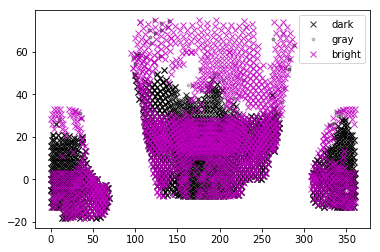

In [44]:
from desisurvey.progress import Progress

if os.path.isfile(os.path.join(alldirs['surveydir'], 'progress.fits')):
    Progress(restore='progress.fits').get_exposures().write(os.path.join(alldirs['surveydir'],'exposures.fits'), overwrite=True)
    
    explist = Table.read(os.path.join(alldirs['surveydir'],'exposures.fits'))

    # separate the exposures for dark and bright programs
    isbright = explist['pass'] > 4 
    isgray = explist['pass'] == 4
    isdark = explist['pass'] < 4
    
    exposurefile_bright = os.path.join(alldirs['surveydir'],'all_exposures_bright.fits')
    Table(explist[isbright]).write(exposurefile_bright, overwrite=True)

    exposurefile_dark = os.path.join(alldirs['surveydir'],'all_exposures_dark.fits')
    Table(explist[~isbright]).write(exposurefile_dark, overwrite=True)
    
    # Make a simple plot
    plt.plot(explist['ra'][isdark], explist['dec'][isdark], 'kx', alpha=0.8, label='dark')
    plt.plot(explist['ra'][isgray], explist['dec'][isgray], 'k.', alpha=0.2, label='gray')
    plt.plot(explist['ra'][isbright], explist['dec'][isbright], 'mx', alpha=0.8, label='bright')
    plt.legend(loc='upper right')

# Select a subset of tiles

We pick 20 tiles nearest RA=180, dec=18. That are already included in the survey simulation outputs.
`fiberassign` will run on those tiles.

In [45]:
tiles = desimodel.io.load_tiles()
explist = Table.read(os.path.join(alldirs['surveydir'],'exposures.fits'))

In [46]:
ntiles = 20

xtiles = tiles[np.in1d(tiles['TILEID'], explist['tileid'])]
xyz = hp.ang2vec(xtiles['ra'], xtiles['dec'], lonlat=True)
center = hp.ang2vec(180, 18, lonlat=True)
d2 = ((xyz - center)**2).sum(axis=1)
ii = np.argsort(d2)[0:ntiles]
xtiles = xtiles[ii]

nexp = np.count_nonzero(np.in1d(explist['tileid'], xtiles['TILEID']))
print('{} tiles covered by {} exposures'.format(len(xtiles), nexp))

20 tiles covered by 33 exposures


In [47]:
#- row indices of exposures of the selected tiles
iobs = np.where(np.in1d(explist['tileid'], xtiles['TILEID']))[0]
assert np.all(np.in1d(explist['tileid'][iobs], xtiles['TILEID']))
print(iobs)

# The exposure list could have a repeated tileid. That would mean that 
# the tile had to be targetted more than once.
explist[iobs]

[ 533  534  769  770  906  907  953  954 1235 1236 1237 1238 1280 1281 1786
 1887 1888 2070 2071 2072 2073 2346 2347 2348 2387 2441 2442 2541 2542 3827
 3828 3863 3894]


tileid,pass,ra,dec,ebmv,night,mjd,exptime,seeing,transparency,airmass,moonfrac,moonalt,moonsep
,,,,,,,s,arcsec,,,,deg,deg
int32,int16,float64,float64,float32,str10,float64,float64,float64,float64,float64,float64,float64,float64
28522,4,178.48,15.73,0.0423507,2019-12-22,58840.5165736,779.645150798,0.813759863377,0.920826971531,1.06578261356,0.0997386220394,5.8848570772,66.2024111436
28522,4,178.48,15.73,0.0423507,2019-12-22,58840.5269862,762.301760085,0.813759863377,0.920826971531,1.06578261356,0.0997386220394,5.8848570772,66.2024111436
2812,0,180.0,15.83,0.0383665,2019-12-30,58848.5039011,716.288214843,1.1069227457,0.980842471123,1.05912436941,0.240230044044,-69.738675827,163.7188271
2812,0,180.0,15.83,0.0383665,2019-12-30,58848.5135804,692.01010596,1.1069227457,0.980842471123,1.05912436941,0.240230044044,-69.738675827,163.7188271
2816,0,181.5,18.38,0.0291605,2020-01-03,58852.4975099,674.821162938,1.00861132145,0.917113542557,1.04573990276,0.60504166833,-38.6150001811,145.217429659
2816,0,181.5,18.38,0.0291605,2020-01-03,58852.5067093,837.253546377,1.00861132145,0.917113542557,1.04573990276,0.60504166833,-38.6150001811,145.217429659
5477,0,178.5,18.38,0.0347319,2020-01-04,58853.4906076,591.160355461,1.08282589912,0.905983805656,1.04160046199,0.697037205017,-26.7284112578,131.543081872
5477,0,178.5,18.38,0.0347319,2020-01-04,58853.4988386,686.689088347,1.08282589912,0.905983805656,1.04160046199,0.697037205017,-26.7284112578,131.543081872


In [48]:
# save the reduce list of exposures for bright and dark/gray survey
mini_explist = explist[iobs]
isbright = mini_explist['pass'] > 4

exposurefile_bright = os.path.join(surveydir,'mini_exposures_bright.fits')
Table(mini_explist[isbright]).write(exposurefile_bright, overwrite=True)


exposurefile_dark = os.path.join(surveydir,'mini_exposures_dark.fits')
Table(mini_explist[~isbright]).write(exposurefile_dark, overwrite=True)


exposurefile = os.path.join(surveydir,'mini_exposures.fits')
Table(mini_explist).write(exposurefile, overwrite=True)

In [49]:
Table(mini_explist[isbright])

tileid,pass,ra,dec,ebmv,night,mjd,exptime,seeing,transparency,airmass,moonfrac,moonalt,moonsep
,,,,,,,s,arcsec,,,,deg,deg
int32,int16,float64,float64,float32,str10,float64,float64,float64,float64,float64,float64,float64,float64
34284,5,179.56,15.71,0.0397849,2020-02-03,58883.4120587,389.298731366,0.749344289303,0.990513026714,1.05466244106,0.715661244866,2.00437158379,102.52759903
34280,5,177.89,18.24,0.0351981,2020-03-03,58912.3101413,634.216437929,1.43911993504,0.37843105197,1.06447327521,0.64988938111,27.4752497921,80.3636648367
34280,5,177.89,18.24,0.0351981,2020-03-03,58912.3188707,587.795705101,1.43911993504,0.37843105197,1.06447327521,0.64988938111,27.4752497921,80.3636648367
34285,5,180.9,18.26,0.0293757,2020-03-03,58912.3270628,432.488326209,1.0773627758,0.931544482708,1.05212034077,0.64988938111,22.5825831672,82.8337194701
34281,5,179.21,20.76,0.0305995,2020-03-04,58913.3021122,536.617091303,1.14801216125,0.978813529015,1.06851214777,0.748793155325,41.4850519411,67.6446535464
40046,6,180.64,15.68,0.0363845,2020-05-11,58981.1383438,375.609948746,1.23665261269,0.99452996254,1.06372200736,0.724207280023,-43.8206417472,119.340682488
40042,6,178.97,18.22,0.0331802,2020-05-11,58981.14408,498.018477556,1.56866669655,0.993786454201,1.04083371133,0.724207280023,-42.4557302888,121.718300026
40047,6,181.98,18.23,0.0308561,2020-05-13,58983.1395616,331.431198549,0.89466303587,0.994367897511,1.04703657781,0.529569920967,-61.9796938898,142.995506122


In [50]:
Table(mini_explist[~isbright])

tileid,pass,ra,dec,ebmv,night,mjd,exptime,seeing,transparency,airmass,moonfrac,moonalt,moonsep
,,,,,,,s,arcsec,,,,deg,deg
int32,int16,float64,float64,float32,str10,float64,float64,float64,float64,float64,float64,float64,float64
28522,4,178.48,15.73,0.0423507,2019-12-22,58840.5165736,779.645150798,0.813759863377,0.920826971531,1.06578261356,0.0997386220394,5.8848570772,66.2024111436
28522,4,178.48,15.73,0.0423507,2019-12-22,58840.5269862,762.301760085,0.813759863377,0.920826971531,1.06578261356,0.0997386220394,5.8848570772,66.2024111436
2812,0,180.0,15.83,0.0383665,2019-12-30,58848.5039011,716.288214843,1.1069227457,0.980842471123,1.05912436941,0.240230044044,-69.738675827,163.7188271
2812,0,180.0,15.83,0.0383665,2019-12-30,58848.5135804,692.01010596,1.1069227457,0.980842471123,1.05912436941,0.240230044044,-69.738675827,163.7188271
2816,0,181.5,18.38,0.0291605,2020-01-03,58852.4975099,674.821162938,1.00861132145,0.917113542557,1.04573990276,0.60504166833,-38.6150001811,145.217429659
2816,0,181.5,18.38,0.0291605,2020-01-03,58852.5067093,837.253546377,1.00861132145,0.917113542557,1.04573990276,0.60504166833,-38.6150001811,145.217429659
5477,0,178.5,18.38,0.0347319,2020-01-04,58853.4906076,591.160355461,1.08282589912,0.905983805656,1.04160046199,0.697037205017,-26.7284112578,131.543081872
5477,0,178.5,18.38,0.0347319,2020-01-04,58853.4988386,686.689088347,1.08282589912,0.905983805656,1.04160046199,0.697037205017,-26.7284112578,131.543081872


Plot the tiles and pixels

(13, 23)

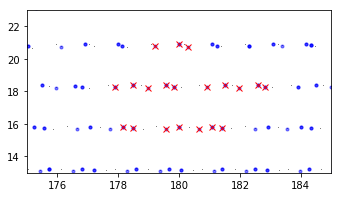

In [51]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plt.plot(x,y, '-', color=color)


plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(tiles['RA'], tiles['DEC'], 'k,', alpha=0.5)
plt.plot(explist['ra'], explist['dec'], 'b.', alpha=0.5)
plt.plot(xtiles['RA'], xtiles['DEC'], 'rx')
plt.xlim(0,360); plt.ylim(-20, 80)

plt.xlim(175, 185); plt.ylim(13, 23)

In [52]:
#- Write subset of tiles table to file for input to select_mock_targets --no-spectra
tilefile = os.path.join(alldirs['darktargetdir'],'test-tiles.fits')
Table(xtiles).write(tilefile, overwrite=True)

tilefile = os.path.join(alldirs['brighttargetdir'],'test-tiles.fits')
Table(xtiles).write(tilefile, overwrite=True)
Table(xtiles)

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
28523,179.82,18.28,4,1,0.0313865,1.05912,1264.66,1.30052,GRAY,2
11239,179.58,18.36,1,1,0.0315597,1.05874,1255.09,1.3013,DARK,1
34285,180.9,18.26,5,1,0.0293757,1.05921,1317.01,1.28485,BRIGHT,4
40042,178.97,18.22,6,1,0.0331802,1.05941,1279.58,1.31524,BRIGHT,4
5477,178.5,18.38,0,1,0.0347319,1.05864,1288.91,1.32651,DARK,1
2816,181.5,18.38,0,1,0.0291605,1.05864,1349.34,1.2823,DARK,1
40047,181.98,18.23,6,1,0.0308561,1.05936,1377.31,1.2967,BRIGHT,4
34280,177.89,18.24,5,1,0.0351981,1.05931,1293.38,1.33133,BRIGHT,4
2812,180.0,15.83,0,1,0.0383665,1.07202,1529.38,1.37763,DARK,1


# Run serial select_mock_targets --no-spectra

In [53]:
select_mock_targets_cmd  = "select_mock_targets --no-spectra -c {yamlconfigfile} --nside {healpixnside} --output_dir {outputdir} --seed {seed} --tiles {tilefile}"

cmd = select_mock_targets_cmd.format(yamlconfigfile=os.path.join(alldirs['darktargetdir'],'select-mock-targets-dark.yaml'),
                                    healpixnside=16,
                                    outputdir=darktargetdir,
                                    seed=10,
                                    tilefile=os.path.join(alldirs['darktargetdir'],'test-tiles.fits'))
print('# Copy and paste this command into a login terminal:\n')
print(cmd)

# Copy and paste this command into a login terminal:

select_mock_targets --no-spectra -c /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark/select-mock-targets-dark.yaml --nside 16 --output_dir /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark --seed 10 --tiles /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark/test-tiles.fits


In [54]:
cmd = "join_mock_targets --force --mockdir "+darktargetdir
print('# Copy and paste this command into a login terminal:\n')
print(cmd)

# Copy and paste this command into a login terminal:

join_mock_targets --force --mockdir /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark


In [55]:
# some sanity checks on the results

In [56]:
targets = fitsio.read(os.path.join(alldirs['darktargetdir'],'targets.fits'))
truth   = fitsio.read(os.path.join(alldirs['darktargetdir'],'truth.fits'))
mtl     = fitsio.read(os.path.join(alldirs['darktargetdir'],'mtl.fits'))
std     = fitsio.read(os.path.join(alldirs['darktargetdir'],'standards-dark.fits'))
sky     = fitsio.read(os.path.join(alldirs['darktargetdir'],'sky.fits'))

In [57]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))

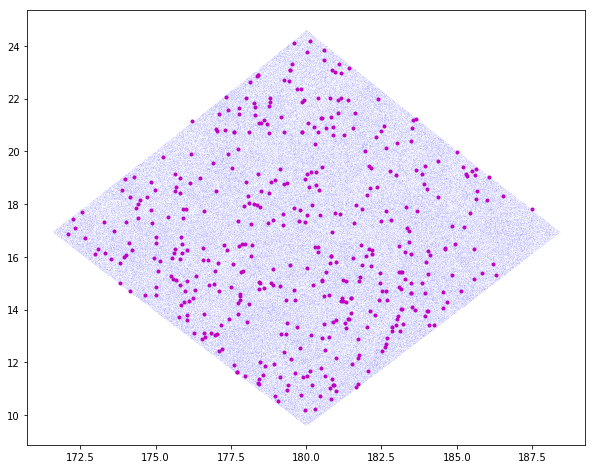

In [58]:
plt.figure(figsize=(10,8))
plt.scatter(mtl['RA'], mtl['DEC'], color='blue', alpha=0.1, s=0.01)
plt.plot(std['RA'], std['DEC'], 'm.')

# Run quicksurvey


## Fiberassign dates

From the `surveysim` data we have to find the dates when `fiberassign` is expected to be run

In [59]:
def compute_fiberassign_dates(exposurefile, outputfile):
    """
    Computes the dates to read fiberassign from the data in a 'exposures' files.
    
    Args:
        exposurefile (str):
        Name of the file with 'exposures' data
    Return:
        fiberassign_dates_run (list):
        List of string dates where fiberassign should be run.
    """
    desisurvey_path = os.getenv('DESISURVEY_OUTPUT')
    exposures = Table.read(exposurefile)
    expdates = []
    for n in exposures['night']:
        a = datetime.datetime.strptime(n, "%Y-%m-%d")
        expdates.append(a.date())
    expdates = np.array(expdates)

    # compute the dates for fiberassign
    progress = Table.read(os.path.join(desisurvey_path,'progress.fits'))
    fiberassign_dates = np.sort(list(set(progress['available'])))
    fiberassign_dates = fiberassign_dates[fiberassign_dates>0]
    
    #load the first date of the survey
    survey_config = os.path.join(desisurvey_path,'config.yaml')
    with open(survey_config, 'r') as pfile:
        params = yaml.load(pfile)
    pfile.close()
    first_day = params['first_day']
    last_day = params['last_day']
 #   print(first_day, last_day)
    
    #compute the dates to run fiberassign to be sure that there is at least one exposure there
    fiberassign_dates_run = []
    one_day = datetime.timedelta(days=1)
    initial_day = first_day 
    for d in fiberassign_dates:
        final_day = first_day + d * one_day
        ii = (expdates > initial_day) & (expdates<=final_day)
        n_in = np.count_nonzero(ii)
        if n_in>0:
#            print(initial_day, final_day, n_in)
            fiberassign_dates_run.append(initial_day.strftime("%Y-%m-%d"))
            initial_day = final_day
    f = open(outputfile, 'w')
    for d in fiberassign_dates_run:
        f.write(d+"\n")
    f.close()

In [60]:
fiberassignfile_dates_dark = os.path.join(alldirs['fiberassigndir'], 'fiberassign_dates_dark.txt')
compute_fiberassign_dates(exposurefile_dark, fiberassignfile_dates_dark)

In [61]:
! cat $fiberassignfile_dates_dark

2019-12-01
2020-01-10
2020-02-08
2020-03-08


In [62]:
quicksurvey_cmd = "quicksurvey -T {targetdir} -E {exposures}  --output_dir {outputdir} -f $(which fiberassign)"
quicksurvey_cmd += " -t {fiberassign_template} -D {fiberassign_dates}"

cmd = quicksurvey_cmd.format(targetdir=alldirs['darktargetdir'],
                            exposures=alldirs['surveydir']+'/mini_exposures_dark.fits', 
                            outputdir=alldirs['zcatdarkdir'], 
                            fiberassign_template=alldirs['fiberassigndir']+'/template_fiberassign_dark.txt', 
                            fiberassign_dates=alldirs['fiberassigndir']+'/fiberassign_dates_dark.txt')
print('# Copy and paste this command into a login terminal:\n')
print(cmd)

# Copy and paste this command into a login terminal:

quicksurvey -T /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark -E /global/cscratch1/sd/forero/quicksurvey_example/survey/mini_exposures_dark.fits  --output_dir /global/cscratch1/sd/forero/quicksurvey_example/zcat/dark -f $(which fiberassign) -t /global/cscratch1/sd/forero/quicksurvey_example/fiberassign/template_fiberassign_dark.txt -D /global/cscratch1/sd/forero/quicksurvey_example/fiberassign/fiberassign_dates_dark.txt


# Read the final redshift catalog

Read the final redshift catalog.

Blue: input catalog.
Red: objects with a redshift.

54015


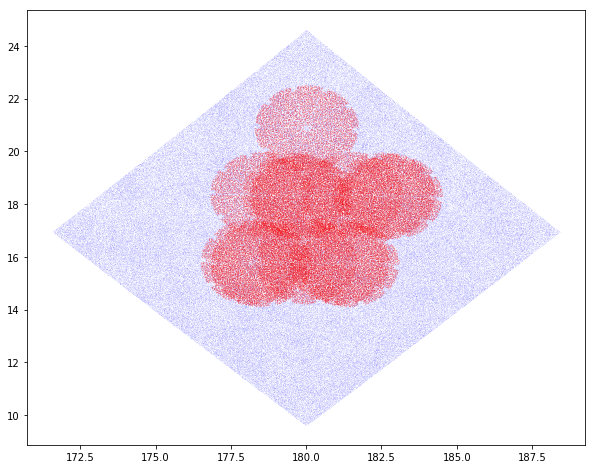

In [63]:
zcat     = fitsio.read(zcatdarkdir+'/3/zcat.fits')
zcat_in_mtl = np.in1d(mtl['TARGETID'], zcat['TARGETID'])
plt.figure(figsize=(10,8))
plt.scatter(mtl['RA'], mtl['DEC'], c='b', alpha=0.1, s=0.01)
plt.scatter(mtl[zcat_in_mtl]['RA'], mtl[zcat_in_mtl]['DEC'], c='r', alpha=0.4, s=0.05)
print(np.count_nonzero(zcat_in_mtl))

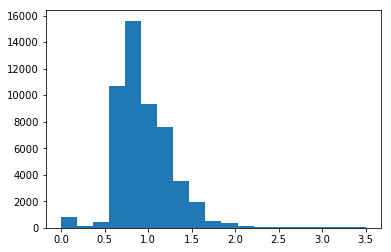

In [64]:
a = plt.hist(zcat['Z'], bins=np.linspace(0.0,3.5,20))